In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sps
import datetime
%matplotlib inline

# global stock dataframe
stock_df = ''

In [2]:
stocks_df = pd.read_csv('nyse/prices-split-adjusted.csv')
fundamentals = pd.read_csv('nyse/fundamentals.csv')
apple_df = stocks_df[stocks_df['symbol'] == 'AAPL']
apple_high_df1_np = apple_df['high'].values
#df1['high'].sort_values(by=['date']).values
apple_df.sort_values(by=['date'])
apple_high_df1_np

array([  30.64285657,   30.79857057,   30.74714286, ...,  118.019997  ,
        117.110001  ,  117.199997  ])

In [3]:
apple_mean = np.mean(apple_high_df1_np)
apple_sd = np.std(apple_high_df1_np)
print('mean: ', apple_mean, '\nsd: ', apple_sd)

mean:  80.1404466937 
sd:  28.5529213874


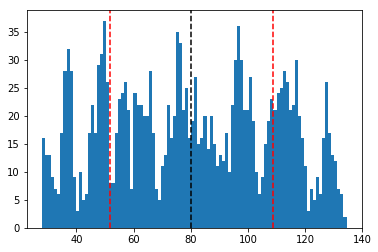

In [4]:
plt.hist(apple_high_df1_np, 100)
plt.axvline(x=apple_mean,linestyle='dashed',color='black')
plt.axvline(x=apple_mean+apple_sd,linestyle='dashed', color='red')
plt.axvline(x=apple_mean-apple_sd,linestyle='dashed', color='red')
plt.show()

In [5]:
apple_df['high'].describe()

count    1762.000000
mean       80.140447
std        28.561027
min        28.000000
25%        55.909286
50%        79.344284
75%       104.424997
max       134.539993
Name: high, dtype: float64

In [6]:
def DescribeStock( symbol, column ):
    global stock_df
    print('symbol: ',symbol, ' column: ', column)
    stock_df = stocks_df[stocks_df['symbol'] == symbol]
    stock_np = stock_df[column].values
    print(stock_df[column].describe())
    return

In [7]:
def Histogram( stock, column, bins ):
    stock_df = stocks_df[stocks_df['symbol'] == stock]
    #print(stock_df)
    stk_mean = np.mean(stock_df[column].values)
    stk_sd = np.std(stock_df[column].values)
    plt.hist(stock_df[column].values, bins)
    plt.axvline(x=apple_mean,linestyle='dashed',color='black')
    plt.axvline(x=apple_mean+apple_sd,linestyle='dashed', color='red')
    plt.axvline(x=apple_mean-apple_sd,linestyle='dashed', color='red')
    plt.show()
    return

In [139]:
def Calculate_T_Value(symbol, feature_a, feature_b, year):
    #Year filter
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
    datetime1 = datetime.date(year,1,1) 
    ByYear = stocks_df['date'] >= datetime1
    
    #Symbol Filter
    BySymbol = stocks_df['symbol'] == symbol

    stock_df = stocks_df[BySymbol & ByYear]
    stock_feature_a_np = stock_df[feature_a].values
    stock_feature_b_np = stock_df[feature_b].values
    
    # t-value use scipy
    from scipy.stats import ttest_ind
    print(ttest_ind(stock_feature_b_np, stock_feature_a_np, equal_var=False))
    return

In [140]:
stocks_df.head(1)
Calculate_T_Value('AAPL', 'high', 'volume', 2016)

Ttest_indResult(statistic=35.688898820158748, pvalue=2.5697502700918627e-100)


In [100]:
def DescribeStockByYear( symbol, column, year ):
    global stock_df
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
    datetime1 = datetime.date(year,1,1) 
    ByYear = stocks_df['date'] >= datetime1
    BySymbol = stocks_df['symbol'] == symbol
    print('symbol: ',symbol, ' summary-year: ', year)
    stock_df = stocks_df[BySymbol & ByYear]
    stock_np = stock_df[column].values
    #print(stock_df[column].describe().mean)
    summary = stock_df[column].describe()
    summary_list = list(summary)
    print('\tmean: ', summary_list[1], '\n\tstd: ', summary_list[2])
    #print(summary)
    return summary_list

In [143]:
symbol = 'AAPL'
column = 'high'
summary_2016 = DescribeStockByYear(symbol, column, 2016)
summary_2015 = DescribeStockByYear(symbol, column, 2015)
summary_2014 = DescribeStockByYear(symbol, column, 2014)
summary_2013 = DescribeStockByYear(symbol, column, 2013)
summary_2013_2016 = [summary_2013[1],summary_2014[1],summary_2015[1],summary_2016[1]]

symbol:  AAPL  summary-year:  2016
	mean:  105.427182544 
	std:  7.55437616907
symbol:  AAPL  summary-year:  2015
	mean:  113.3358532 
	std:  10.9069515877
symbol:  AAPL  summary-year:  2014
	mean:  106.56145693 
	std:  15.2403230075
symbol:  AAPL  summary-year:  2013
	mean:  96.9796258129 
	std:  21.4463933291


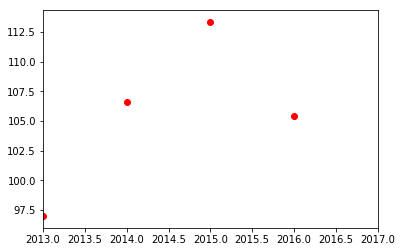

In [144]:
plt.plot([2013,2014,2015,2016], [summary_2013[1],summary_2014[1],summary_2015[1],summary_2016[1]], 'ro')
plt.axis([2013, 2017, (min(summary_2013_2016)-1),(max(summary_2013_2016)+1)])
#plt.xticks(np.arange( 2013, 2016, 1.0))
plt.show()

In [92]:
symbol = 'AAPL'
column = 'high'
DescribeStock(symbol, column)

symbol:  AAPL  column:  high
count    1762.000000
mean       80.140447
std        28.561027
min        28.000000
25%        55.909286
50%        79.344284
75%       104.424997
max       134.539993
Name: high, dtype: float64


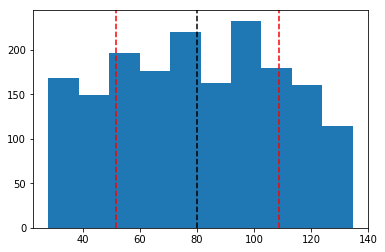

In [9]:
Histogram(symbol, column, 10)

In [10]:
stock_df.head(5)

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [11]:
#fundamentals.head(5)
stk = fundamentals[fundamentals['Ticker Symbol'] == symbol]
stk

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
8,8,AAPL,2013-09-28,3.622300e+10,-1.949000e+09,1.156000e+09,30.0,-8.165000e+09,0.0,93.0,...,7.328600e+10,4.365800e+10,1.235490e+11,8.345100e+10,2.070000e+11,1.709100e+11,0.0,2013.0,40.03,9.252311e+08
9,9,AAPL,2014-09-27,4.864900e+10,-6.452000e+09,9.800000e+08,35.0,-9.571000e+09,0.0,40.0,...,6.853100e+10,6.344800e+10,1.115470e+11,1.202920e+11,2.318390e+11,1.827950e+11,0.0,2014.0,6.49,6.087827e+09
10,10,AAPL,2015-09-26,6.067100e+10,-3.124000e+09,1.285000e+09,45.0,-1.124700e+10,0.0,52.0,...,8.937800e+10,8.061000e+10,1.193550e+11,1.709900e+11,2.903450e+11,2.337150e+11,0.0,2015.0,9.28,5.753664e+09
11,11,AAPL,2016-09-24,5.932100e+10,1.044000e+09,1.348000e+09,36.0,-1.273400e+10,0.0,85.0,...,1.068690e+11,7.900600e+10,1.282490e+11,1.934370e+11,3.216860e+11,2.156390e+11,0.0,2016.0,8.35,5.471497e+09


In [12]:
stocks_df.symbol.unique()

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN',
       'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX',
       'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK',
       'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH',
       'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF',
       'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA',
       'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH',
       'COL', 'COO', 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE',
       'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 